In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point,LineString
from pyproj import Proj, Transformer
import pickle
import itertools
import random
from sympy import symbols, Eq, solve

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Tram-Amsterdam

## Generate Baseline Networks

In [4]:
city_tram_stations, edges, nodes, city_tram_routes = prepare_tram(osm_path)

topology: 100%|██████████████████████████████████████████████████████████████████| 2204/2204 [00:00<00:00, 9194.95it/s]


Calculate_degree possibly unhappy


In [5]:
id_nodes_length_tram = len(nodes)
id_edges_length_tram = len(edges)

In [6]:
city_tram_edges = pd.DataFrame(edges.copy())
city_tram_nodes = pd.DataFrame(nodes.copy())

In [7]:
city_tram_edges

osm_id                                           geometry railway  \
0        7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
1        7045616  LINESTRING (4.934085 52.3609657, 4.9340765 52....    tram   
2        7045675  LINESTRING (4.9337809 52.3611734, 4.9339017 52...    tram   
3        7045689  LINESTRING (4.9394 52.361617, 4.9385742 52.361...    tram   
4        7045994  LINESTRING (4.9157261 52.365067, 4.9157046 52....    tram   
...          ...                                                ...     ...   
2199  1185084715  LINESTRING (4.8520736 52.3479443, 4.8521852 52...    tram   
2200  1185084716  LINESTRING (4.852325 52.3480075, 4.852489 52.3...    tram   
2201  1185084717  LINESTRING (4.8516012 52.3470208, 4.8519064 52...    tram   
2202  1185084718  LINESTRING (4.8522982 52.348033, 4.8524709 52....    tram   
2203  1185084719  LINESTRING (4.851576 52.3470746, 4.8518677 52....    tram   

     service    id  from_id  to_id    distance      time  weights  \
0       None     0        0      1   28.561299  0.002040       28   
1       None     1        2      3  146.082551  0.010434      146   
2       None     2        4      5  390.987463  0.027928      390   
3       None     3        6      7  345.247175  0.024661      345   
4       None     4        8   1730   35.152166  0.002511       35   
...      ...   ...      ...    ...         ...       ...      ...   
2199    None  2199     1496    594   11.280287  0.000806       11   
2200    None  2200      562   1072   12.010525  0.000858       12   
2201    None  2201     1497    561   81.765515  0.005840       81   
2202    None  2202      566   1079   12.587379  0.000899       12   
2203    None  2203      552    565   78.206965  0.005586       78   

          to_from      from_to  
0          (0, 1)       (1, 0)  
1          (2, 3)       (3, 2)  
2          (4, 5)       (5, 4)  
3          (6, 7)       (7, 6)  
4       (8, 1730)    (1730, 8)  
...           ...          ...  
2199  (1496, 594)  (594, 1496)  
2200  (562, 1072)  (1072, 562)  
2201  (1497, 561)  (561, 1497)  
2202  (566, 1079)  (1079, 566)  
2203   (552, 565)   (565, 552)  

[2204 rows x 12 columns]

In [8]:
# city_tram_nodes['id'] = city_tram_nodes['id'] + id_nodes_length_sub

# city_tram_edges['id'] = city_tram_edges['id'] + id_edges_length_sub
# city_tram_edges['from_id'] = city_tram_edges['from_id'] + id_nodes_length_sub
# city_tram_edges['to_id'] = city_tram_edges['to_id'] + id_nodes_length_sub

In [9]:
# city_tram_edges['from_to'] = list(zip(city_tram_edges.from_id, city_tram_edges.to_id))
# city_tram_edges['to_from'] = list(zip(city_tram_edges.to_id, city_tram_edges.from_id))

In [10]:
# Delete edges which can cause the differences with routes
# tram 26-2
# city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2310) & (city_tram_edges['to_id'] == 1546)].index, inplace=True)
# # tram 4,14,24
# city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2150) & (city_tram_edges['to_id'] == 1201)].index, inplace=True)
# city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1806) & (city_tram_edges['to_id'] == 2150)].index, inplace=True)

In [11]:
city_tram_edges

osm_id                                           geometry railway  \
0        7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
1        7045616  LINESTRING (4.934085 52.3609657, 4.9340765 52....    tram   
2        7045675  LINESTRING (4.9337809 52.3611734, 4.9339017 52...    tram   
3        7045689  LINESTRING (4.9394 52.361617, 4.9385742 52.361...    tram   
4        7045994  LINESTRING (4.9157261 52.365067, 4.9157046 52....    tram   
...          ...                                                ...     ...   
2199  1185084715  LINESTRING (4.8520736 52.3479443, 4.8521852 52...    tram   
2200  1185084716  LINESTRING (4.852325 52.3480075, 4.852489 52.3...    tram   
2201  1185084717  LINESTRING (4.8516012 52.3470208, 4.8519064 52...    tram   
2202  1185084718  LINESTRING (4.8522982 52.348033, 4.8524709 52....    tram   
2203  1185084719  LINESTRING (4.851576 52.3470746, 4.8518677 52....    tram   

     service    id  from_id  to_id    distance      time  weights  \
0       None     0        0      1   28.561299  0.002040       28   
1       None     1        2      3  146.082551  0.010434      146   
2       None     2        4      5  390.987463  0.027928      390   
3       None     3        6      7  345.247175  0.024661      345   
4       None     4        8   1730   35.152166  0.002511       35   
...      ...   ...      ...    ...         ...       ...      ...   
2199    None  2199     1496    594   11.280287  0.000806       11   
2200    None  2200      562   1072   12.010525  0.000858       12   
2201    None  2201     1497    561   81.765515  0.005840       81   
2202    None  2202      566   1079   12.587379  0.000899       12   
2203    None  2203      552    565   78.206965  0.005586       78   

          to_from      from_to  
0          (0, 1)       (1, 0)  
1          (2, 3)       (3, 2)  
2          (4, 5)       (5, 4)  
3          (6, 7)       (7, 6)  
4       (8, 1730)    (1730, 8)  
...           ...          ...  
2199  (1496, 594)  (594, 1496)  
2200  (562, 1072)  (1072, 562)  
2201  (1497, 561)  (561, 1497)  
2202  (566, 1079)  (1079, 566)  
2203   (552, 565)   (565, 552)  

[2204 rows x 12 columns]

In [12]:
city_tram_nodes

geometry  degree    id
0     POINT (4.9324018 52.3610615)       3     0
1      POINT (4.9321097 52.361227)       3     1
2      POINT (4.934085 52.3609657)       3     2
3      POINT (4.933017 52.3603624)       3     3
4     POINT (4.9337809 52.3611734)       3     4
...                            ...     ...   ...
1915  POINT (4.9009826 52.3777045)       0  1915
1916   POINT (4.890644 52.3719008)       2  1916
1917  POINT (4.9899502 52.3580579)       2  1917
1918   POINT (4.9272548 52.357015)       0  1918
1919  POINT (4.9268761 52.3574304)       0  1919

[1920 rows x 3 columns]

In [13]:
city_tram_routes = city_tram_routes.loc[city_tram_routes.ref != 'EMA']

In [14]:
city_tram_routes, check_name = check_tram_routes(city_tram_stations, city_tram_routes)

In [15]:
replacement_dict = {
    ',': '',
    'Diemen': '',
    'Amsterdam': '',
    'Sloterdijk': 'Station Sloterdijk',
    'Osdorp Dijkgraafsplein': 'Dijkgraafplein',
    'Osdorp De Aker': 'Matterhorn'
}

city_tram_stations, city_tram_routes, check_name = recheck_tram_routes(replacement_dict, city_tram_stations, city_tram_routes)

In [16]:
replacement_dict = {
    'Amstelveen Westwijk': 'Westwijk'
}

city_tram_stations, city_tram_routes, check_name = recheck_tram_routes(replacement_dict, city_tram_stations, city_tram_routes)

In [17]:
# # city_tram_stations.to_excel('.\city_tram_stations.xlsx',header = True,index = False)

In [18]:
# Create a dictionary mapping start stations to their corresponding routes
city_tram_start_station_name_dict = start_station_dict(city_tram_routes)

# Create a dictionary mapping tram lines to their corresponding routes
city_tram_line_dict = line_dict(city_tram_routes)

# Create a list of all station names in the city's tram network
city_all_tram_stations_name = all_station_list(city_tram_stations)

# Create a dictionary mapping tram lines to the ordered list of stations on each line
city_tram_order_route_dict = order_stations_inline(city_tram_line_dict, city_all_tram_stations_name, city_tram_routes, city_tram_start_station_name_dict)

# Create a dictionary mapping tram lines to the pairs of station IDs on each line
city_tram_order_id_pairs = id_pairs_inline(city_tram_line_dict, city_tram_order_route_dict, city_tram_nodes)

# Create a graph representing the tram network using the extracted edges and nodes
G = create_ground_graph(city_tram_edges, city_tram_nodes)

# Calculate the shortest path pairs for each tram line
city_tram_all_shortest_paths_id_dict = city_tram_order_id_pairs.copy()


for line in city_tram_order_id_pairs.keys():
    
    city_tram_all_shortest_paths_id_dict[line] = all_shortest_path_id_list(G, city_tram_order_id_pairs[line], city_tram_edges)

In [19]:
city_tram_ordered_edges = edges_revise_direction(city_tram_all_shortest_paths_id_dict,city_tram_edges)
city_tram_ordered_edges

from_id  to_id      osm_id  \
0           0      1     7045610   
1           2      3     7045616   
2           4      5     7045675   
3           6      7     7045689   
4           8   1730     7045994   
...       ...    ...         ...   
2199     1496    594  1185084715   
2200      562   1072  1185084716   
2201     1497    561  1185084717   
2202      566   1079  1185084718   
2203      552    565  1185084719   

                                               geometry railway service    id  \
0     LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram    None     0   
1     LINESTRING (4.934085 52.3609657, 4.9340765 52....    tram    None     1   
2     LINESTRING (4.9337809 52.3611734, 4.9339017 52...    tram    None     2   
3     LINESTRING (4.9394 52.361617, 4.9385742 52.361...    tram    None     3   
4     LINESTRING (4.9157261 52.365067, 4.9157046 52....    tram    None     4   
...                                                 ...     ...     ...   ...   
2199  LINESTRING (4.8520736 52.3479443, 4.8521852 52...    tram    None  2199   
2200  LINESTRING (4.852325 52.3480075, 4.852489 52.3...    tram    None  2200   
2201  LINESTRING (4.8516012 52.3470208, 4.8519064 52...    tram    None  2201   
2202  LINESTRING (4.8522982 52.348033, 4.8524709 52....    tram    None  2202   
2203  LINESTRING (4.851576 52.3470746, 4.8518677 52....    tram    None  2203   

        distance      time  weights      from_to      to_from  
0      28.561299  0.002040       28       (0, 1)       (1, 0)  
1     146.082551  0.010434      146       (2, 3)       (3, 2)  
2     390.987463  0.027928      390       (4, 5)       (5, 4)  
3     345.247175  0.024661      345       (6, 7)       (7, 6)  
4      35.152166  0.002511       35    (8, 1730)    (1730, 8)  
...          ...       ...      ...          ...          ...  
2199   11.280287  0.000806       11  (1496, 594)  (594, 1496)  
2200   12.010525  0.000858       12  (562, 1072)  (1072, 562)  
2201   81.765515  0.005840       81  (1497, 561)  (561, 1497)  
2202   12.587379  0.000899       12  (566, 1079)  (1079, 566)  
2203   78.206965  0.005586       78   (552, 565)   (565, 552)  

[2231 rows x 12 columns]

In [20]:
duplicated_rows = city_tram_ordered_edges[city_tram_ordered_edges.index.duplicated(keep=False)]
duplicated_rows

from_id  to_id      osm_id  \
293       335    336    27254598   
293       336    335    27254598   
458       492    491    90119531   
458       491    492    90119531   
624       634    633   191467397   
624       633    634   191467397   
625       633    635   191467407   
625       635    633   191467407   
661       676    677   222748909   
661       677    676   222748909   
762       777    776   312009858   
762       776    777   312009858   
1050      976    977   325204605   
1050      977    976   325204605   
1317     1156   1155   451365640   
1317     1155   1156   451365640   
1337     1167    791   458116526   
1337      791   1167   458116526   
1454     1236    977   582512959   
1454      977   1236   582512959   
1456     1653    976   582512961   
1456      976   1653   582512961   
1522     1155   1152   612073335   
1522     1152   1155   612073335   
1581     1229   1232   653130646   
1581     1232   1229   653130646   
1582     1229   1233   653130646   
1582     1233   1229   653130646   
1664     1191     42   708673972   
1664       42   1191   708673972   
1877      378   1344   772206867   
1877     1344    378   772206867   
1901      773   1156   773850517   
1901     1156    773   773850517   
1906     1347   1226   773877998   
1906     1226   1347   773877998   
1910      709   1348   773878010   
1910     1348    709   773878010   
1913      411   1152   773880554   
1913     1152    411   773880554   
1928      635    518   780625027   
1928      518    635   780625027   
1945      336    333   785957809   
1945      333    336   785957809   
2079      750   1899   847807655   
2079     1899    750   847807655   
2097      335   1167  1006193429   
2097     1167    335  1006193429   
2101     1167    677  1006420684   
2101      677   1167  1006420684   
2102      677    492  1006420685   
2102      492    677  1006420685   
2103      790   1442  1006420686   
2103     1442    790  1006420686   

                                               geometry railway service    id  \
293   LINESTRING (4.8992828 52.3777499, 4.899074 52....    tram    None   293   
293   LINESTRING (4.8992828 52.3777499, 4.899074 52....    tram    None   293   
458   LINESTRING (4.9003819 52.3778942, 4.9003114 52...    tram    None   458   
458   LINESTRING (4.9003819 52.3778942, 4.9003114 52...    tram    None   458   
624   LINESTRING (4.8391817 52.3875635, 4.839195 52....    tram    None   624   
624   LINESTRING (4.8391817 52.3875635, 4.839195 52....    tram    None   624   
625   LINESTRING (4.8391059 52.387403, 4.8391111 52....    tram    None   625   
625   LINESTRING (4.8391059 52.387403, 4.8391111 52....    tram    None   625   
661   LINESTRING (4.9003629 52.3778505, 4.9002941 52...    tram    None   661   
661   LINESTRING (4.9003629 52.3778505, 4.9002941 52...    tram    None   661   
762   LINESTRING (4.8991685 52.3662087, 4.8991313 52...    tram    None   762   
762   LINESTRING (4.8991685 52.3662087, 4.8991313 52...    tram    None   762   
1050  LINESTRING (4.8769861 52.3703587, 4.8769277 52...    tram    None  1050   
1050  LINESTRING (4.8769861 52.3703587, 4.8769277 52...    tram    None  1050   
1317  LINESTRING (4.8978222 52.3651067, 4.8977978 52...    tram    None  1317   
1317  LINESTRING (4.8978222 52.3651067, 4.8977978 52...    tram    None  1317   
1337  LINESTRING (4.9003434 52.3778058, 4.900276 52....    tram    None  1337   
1337  LINESTRING (4.9003434 52.3778058, 4.900276 52....    tram    None  1337   
1454  LINESTRING (4.8769277 52.3704412, 4.8765273 52...    tram    None  1454   
1454  LINESTRING (4.8769277 52.3704412, 4.8765273 52...    tram    None  1454   
1456  LINESTRING (4.8775579 52.3695272, 4.8774741 52...    tram    None  1456   
1456  LINESTRING (4.8775579 52.3695272, 4.8774741 52...    tram    None  1456   
1522  LINESTRING (4.8978788 52.3649076, 4.8978751 52...    tram    None  1522   
1522  LINESTRING (4.8978788 52.3649076, 4.8978751 52...    tram    None  1522   


In [21]:
len(duplicated_rows)

54

In [22]:
# Extract the edges from the input DataFrame and create a list of tuples with time
od = city_tram_ordered_edges[['from_id', 'to_id', 'time']]
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]*60}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)
# edges_list

In [23]:
G = nx.DiGraph()
for _, row in city_tram_nodes.iterrows():
    node = row['id']  # Assuming 'id' is the node identifier
    geometry = row['geometry']
    x, y = geometry.x, geometry.y
    G.add_node(node, pos=(x, y))
G.add_edges_from(edges_list)

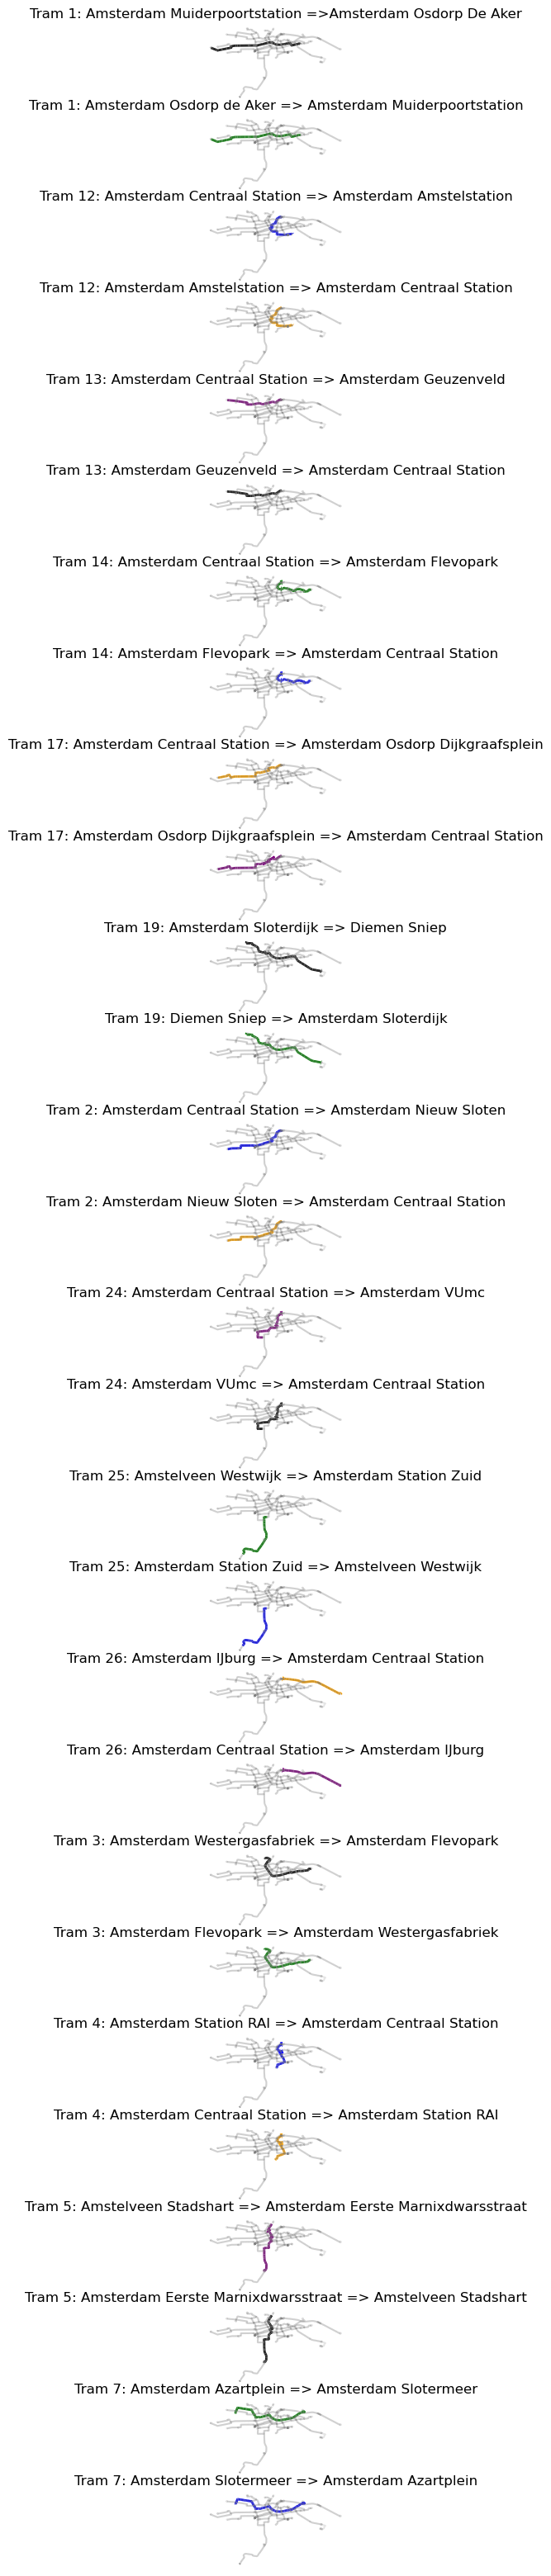

In [24]:
# Calculate the shortest path pairs for each tram line
city_tram_shortest_path_pairs_dict = city_tram_order_id_pairs.copy()
duplicate_row_count = city_tram_order_id_pairs.copy()
city_tram_shortest_path_edges_dict = city_tram_order_id_pairs.copy()
city_tram_edges_dict = city_tram_order_id_pairs.copy()

for line in city_tram_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the tram network edges
    city_tram_shortest_path_pairs_dict[line] = all_shortest_paths(G, city_tram_order_id_pairs[line], city_tram_ordered_edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the tram network edges for the current line
    duplicate_row_count[line], city_tram_shortest_path_edges_dict[line], city_tram_edges_dict[line] = edges_with_count_weight(city_tram_shortest_path_pairs_dict[line], city_tram_ordered_edges)
    
# Plot all tram routes
plot_routes(city_tram_routes, city_tram_ordered_edges, city_tram_shortest_path_edges_dict)

In [71]:
df1_1 = city_tram_shortest_path_edges_dict['Tram 1: Amsterdam Muiderpoortstation =>Amsterdam Osdorp De Aker']
df1_2 = city_tram_shortest_path_edges_dict['Tram 1: Amsterdam Osdorp de Aker => Amsterdam Muiderpoortstation']

df12_1 = city_tram_shortest_path_edges_dict['Tram 12: Amsterdam Centraal Station => Amsterdam Amstelstation']
df12_2 = city_tram_shortest_path_edges_dict['Tram 12: Amsterdam Amstelstation => Amsterdam Centraal Station']

df13_1 = city_tram_shortest_path_edges_dict['Tram 13: Amsterdam Centraal Station => Amsterdam Geuzenveld']
df13_2 = city_tram_shortest_path_edges_dict['Tram 13: Amsterdam Geuzenveld => Amsterdam Centraal Station']

df14_1 = city_tram_shortest_path_edges_dict['Tram 14: Amsterdam Centraal Station => Amsterdam Flevopark']
df14_2 = city_tram_shortest_path_edges_dict['Tram 14: Amsterdam Flevopark => Amsterdam Centraal Station']

df17_1 = city_tram_shortest_path_edges_dict['Tram 17: Amsterdam Centraal Station => Amsterdam Osdorp Dijkgraafsplein']
df17_2 = city_tram_shortest_path_edges_dict['Tram 17: Amsterdam Osdorp Dijkgraafsplein => Amsterdam Centraal Station']

df19_1 = city_tram_shortest_path_edges_dict['Tram 19: Amsterdam Sloterdijk => Diemen Sniep']
df19_2 = city_tram_shortest_path_edges_dict['Tram 19: Diemen Sniep => Amsterdam Sloterdijk']

df2_1 = city_tram_shortest_path_edges_dict['Tram 2: Amsterdam Centraal Station => Amsterdam Nieuw Sloten']
df2_2 = city_tram_shortest_path_edges_dict['Tram 2: Amsterdam Nieuw Sloten => Amsterdam Centraal Station']

df24_1 = city_tram_shortest_path_edges_dict['Tram 24: Amsterdam Centraal Station => Amsterdam VUmc']
df24_2 = city_tram_shortest_path_edges_dict['Tram 24: Amsterdam VUmc => Amsterdam Centraal Station']

df25_1 = city_tram_shortest_path_edges_dict['Tram 25: Amstelveen Westwijk => Amsterdam Station Zuid']
df25_2 = city_tram_shortest_path_edges_dict['Tram 25: Amsterdam Station Zuid => Amstelveen Westwijk']

df26_1 = city_tram_shortest_path_edges_dict['Tram 26: Amsterdam IJburg => Amsterdam Centraal Station']
df26_2 = city_tram_shortest_path_edges_dict['Tram 26: Amsterdam Centraal Station => Amsterdam IJburg']

df3_1 = city_tram_shortest_path_edges_dict['Tram 3: Amsterdam Westergasfabriek => Amsterdam Flevopark']
df3_2 = city_tram_shortest_path_edges_dict['Tram 3: Amsterdam Flevopark => Amsterdam Westergasfabriek']

df4_1 = city_tram_shortest_path_edges_dict['Tram 4: Amsterdam Station RAI => Amsterdam Centraal Station']
df4_2 = city_tram_shortest_path_edges_dict['Tram 4: Amsterdam Centraal Station => Amsterdam Station RAI']

df5_1 = city_tram_shortest_path_edges_dict['Tram 5: Amstelveen Stadshart => Amsterdam Eerste Marnixdwarsstraat']
df5_2 = city_tram_shortest_path_edges_dict['Tram 5: Amsterdam Eerste Marnixdwarsstraat => Amstelveen Stadshart']

df7_1 = city_tram_shortest_path_edges_dict['Tram 7: Amsterdam Azartplein => Amsterdam Slotermeer']
df7_2 = city_tram_shortest_path_edges_dict['Tram 7: Amsterdam Slotermeer => Amsterdam Azartplein']

In [72]:
gpd.GeoDataFrame(df1_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df1_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df1_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df1_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df12_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df12_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df12_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df12_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df13_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df13_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df13_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df13_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df14_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df14_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df14_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df14_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df17_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df17_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df17_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df17_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df19_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df19_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df19_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df19_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df2_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df2_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df2_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df2_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df24_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df24_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df24_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df24_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df25_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df25_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df25_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df25_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df26_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df26_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df26_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df26_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df3_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df3_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df3_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df3_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df4_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df4_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df4_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df4_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df5_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df5_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df5_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df5_2_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df7_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df7_1_0417.GPKG',driver='GPKG')
gpd.GeoDataFrame(df7_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df7_2_0417.GPKG',driver='GPKG')

### Add columns to edges--city_tram_extended_edges

In [27]:
city_tram_shortest_path_edges_dict

{'Tram 1: Amsterdam Muiderpoortstation =>Amsterdam Osdorp De Aker':     from_id  to_id     osm_id  \
 0         0      1    7045610   
 1      1341    628  770429442   
 2       628      0  770429442   
 3         1   1503  770438581   
 4      1503   1606  770438581   
 ..      ...    ...        ...   
 91      189    190   26594761   
 92     1777    189  322841907   
 93      190   1616  322841927   
 94     1616   1615  322841927   
 95     1615    847  322841927   
 
                                              geometry railway service    id  \
 0   LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram    None     0   
 1   LINESTRING (4.9326128 52.3607965, 4.9325204 52...    tram    None  1852   
 2   LINESTRING (4.9325122 52.3609243, 4.9324018 52...    tram    None  1853   
 3   LINESTRING (4.9321097 52.361227, 4.9305569 52....    tram    None  1855   
 4   LINESTRING (4.9289422 52.3609314, 4.9288413 52...    tram    None  1856   
 ..                                        

In [28]:
city_tram_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_tram_shortest_path_edges_dict, city_tram_routes)

In [29]:
city_tram_extended_edges = add_columns_to_edges(city_tram_shortest_path_edges_dict,city_tram_ordered_edges)

In [30]:
# column_to_drop = 'count_weight'
# city_tram_extended_edges = city_tram_extended_edges.drop(columns=column_to_drop)

In [31]:
city_tram_extended_edges

osm_id                                           geometry railway  \
0        7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
1        7045616  LINESTRING (4.934085 52.3609657, 4.9340765 52....    tram   
2        7045675  LINESTRING (4.9337809 52.3611734, 4.9339017 52...    tram   
3        7045689  LINESTRING (4.9394 52.361617, 4.9385742 52.361...    tram   
4        7045994  LINESTRING (4.9157261 52.365067, 4.9157046 52....    tram   
...          ...                                                ...     ...   
2226  1185084715  LINESTRING (4.8520736 52.3479443, 4.8521852 52...    tram   
2227  1185084716  LINESTRING (4.852325 52.3480075, 4.852489 52.3...    tram   
2228  1185084717  LINESTRING (4.8516012 52.3470208, 4.8519064 52...    tram   
2229  1185084718  LINESTRING (4.8522982 52.348033, 4.8524709 52....    tram   
2230  1185084719  LINESTRING (4.851576 52.3470746, 4.8518677 52....    tram   

     service    id  from_id  to_id    distance      time  weights  \
0       None     0        0      1   28.561299  0.002040       28   
1       None     1        2      3  146.082551  0.010434      146   
2       None     2        4      5  390.987463  0.027928      390   
3       None     3        6      7  345.247175  0.024661      345   
4       None     4        8   1730   35.152166  0.002511       35   
...      ...   ...      ...    ...         ...       ...      ...   
2226    None  2199     1496    594   11.280287  0.000806       11   
2227    None  2200      562   1072   12.010525  0.000858       12   
2228    None  2201     1497    561   81.765515  0.005840       81   
2229    None  2202      566   1079   12.587379  0.000899       12   
2230    None  2203      552    565   78.206965  0.005586       78   

          to_from      from_to  count_weight  \
0          (1, 0)       (0, 1)           1.0   
1          (3, 2)       (2, 3)           NaN   
2          (5, 4)       (4, 5)           1.0   
3          (7, 6)       (6, 7)           1.0   
4       (1730, 8)    (8, 1730)           1.0   
...           ...          ...           ...   
2226  (594, 1496)  (1496, 594)           NaN   
2227  (1072, 562)  (562, 1072)           NaN   
2228  (561, 1497)  (1497, 561)           NaN   
2229  (1079, 566)  (566, 1079)           NaN   
2230   (565, 552)   (552, 565)           NaN   

                                        route_name_list route  ref  
0     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram    1  
1                                                   NaN   NaN  NaN  
2     Tram 3: Amsterdam Westergasfabriek => Amsterda...  tram    3  
3     Tram 3: Amsterdam Flevopark => Amsterdam Weste...  tram    3  
4     Tram 14: Amsterdam Flevopark => Amsterdam Cent...  tram   14  
...                                                 ...   ...  ...  
2226                                                NaN   NaN  NaN  
2227                                                NaN   NaN  NaN  
2228                                                NaN   NaN  NaN  
2229                                                NaN   NaN  NaN  
2230                                                NaN   NaN  NaN  

[2231 rows x 16 columns]

### Organize edges dataframe for baseline network--city_tram_new_edges

In [32]:
city_tram_shortest_path_edges_df = pd.concat(city_tram_shortest_path_edges_dict.values()).reset_index(drop=True)
city_tram_shortest_path_edges_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)
city_tram_shortest_path_edges_df

from_id  to_id     osm_id  \
0           0      1    7045610   
1        1341    628  770429442   
2         628      0  770429442   
3           1   1503  770438581   
4        1503   1606  770438581   
...       ...    ...        ...   
1468     1034   1515  597894525   
1469     1515   1751  597894525   
1470      412    413   38365154   
1471      413    414   38365155   
1472     1751    412  597894525   

                                               geometry railway service    id  \
0     LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram    None     0   
1     LINESTRING (4.9326128 52.3607965, 4.9325204 52...    tram    None  1852   
2     LINESTRING (4.9325122 52.3609243, 4.9324018 52...    tram    None  1853   
3     LINESTRING (4.9321097 52.361227, 4.9305569 52....    tram    None  1855   
4     LINESTRING (4.9289422 52.3609314, 4.9288413 52...    tram    None  1856   
...                                                 ...     ...     ...   ...   
1468  LINESTRING (4.9334891 52.3725343, 4.9336504 52...    tram    None  1468   
1469  LINESTRING (4.9348327 52.3730107, 4.9349469 52...    tram    None  1469   
1470  LINESTRING (4.9386339 52.3753347, 4.9383667 52...    tram    None   378   
1471  LINESTRING (4.9383667 52.375575, 4.9379805 52....    tram    None   379   
1472  LINESTRING (4.9381702 52.3734596, 4.9382656 52...    tram    None  1470   

        distance      time  weights       from_to       to_from  count_weight  \
0      28.561299  0.002040       28        (0, 1)        (1, 0)           1.0   
1      15.783121  0.001127       15   (1341, 628)   (628, 1341)           1.0   
2      17.015621  0.001215       17      (628, 0)      (0, 628)           1.0   
3     221.946033  0.015853      221     (1, 1503)     (1503, 1)           1.0   
4     238.554153  0.017040      238  (1503, 1606)  (1606, 1503)           1.0   
...          ...       ...      ...           ...           ...           ...   
1468  106.067531  0.007576      106  (1034, 1515)  (1515, 1034)           1.0   
1469  233.143567  0.016653      233  (1515, 1751)  (1751, 1515)           1.0   
1470   32.337647  0.002310       32    (412, 413)    (413, 412)           1.0   
1471  157.783688  0.011270      157    (413, 414)    (414, 413)           1.0   
1472  358.210747  0.025586      358   (1751, 412)   (412, 1751)           1.0   

                                        route_name_list ref route  
0     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   1  tram  
1     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   1  tram  
2     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   1  tram  
3     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   1  tram  
4     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   1  tram  
...                                                 ...  ..   ...  
1468  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...   7  tram  
1469  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...   7  tram  
1470  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...   7  tram  
1471  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...   7  tram  
1472  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...   7  tram  

[1473 rows x 16 columns]

In [33]:
city_tram_new_edges = pd.merge(city_tram_extended_edges,city_tram_shortest_path_edges_df.geometry,on='geometry',how='inner')
city_tram_new_edges

osm_id                                           geometry railway  \
0        7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
1        7045675  LINESTRING (4.9337809 52.3611734, 4.9339017 52...    tram   
2        7045689  LINESTRING (4.9394 52.361617, 4.9385742 52.361...    tram   
3        7045994  LINESTRING (4.9157261 52.365067, 4.9157046 52....    tram   
4        7045994  LINESTRING (4.9152768 52.3652225, 4.915065 52....    tram   
...          ...                                                ...     ...   
1495  1171248763  LINESTRING (4.8935334 52.3671322, 4.893537 52....    tram   
1496  1171248764  LINESTRING (4.8935276 52.3672065, 4.8935288 52...    tram   
1497  1171248765  LINESTRING (4.8935276 52.3672065, 4.8935224 52...    tram   
1498  1171248766  LINESTRING (4.8935108 52.3671108, 4.8934967 52...    tram   
1499  1172020662  LINESTRING (4.8920868 52.3752328, 4.8920061 52...    tram   

     service    id  from_id  to_id    distance      time  weights  \
0       None     0        0      1   28.561299  0.002040       28   
1       None     2        4      5  390.987463  0.027928      390   
2       None     3        6      7  345.247175  0.024661      345   
3       None     4        8   1730   35.152166  0.002511       35   
4       None     5     1730      9  250.873163  0.017920      250   
...      ...   ...      ...    ...         ...       ...      ...   
1495    None  2154     1459    765   12.550913  0.000896       12   
1496    None  2155     1321   1459    8.277607  0.000591        8   
1497    None  2156     1321   1460   10.712936  0.000765       10   
1498    None  2157     1460    767   19.092914  0.001364       19   
1499    None  2158     1461   1462  109.928912  0.007852      109   

           to_from       from_to  count_weight  \
0           (1, 0)        (0, 1)           1.0   
1           (5, 4)        (4, 5)           1.0   
2           (7, 6)        (6, 7)           1.0   
3        (1730, 8)     (8, 1730)           1.0   
4        (9, 1730)     (1730, 9)           1.0   
...            ...           ...           ...   
1495   (765, 1459)   (1459, 765)           1.0   
1496  (1459, 1321)  (1321, 1459)           1.0   
1497  (1460, 1321)  (1321, 1460)           1.0   
1498   (767, 1460)   (1460, 767)           1.0   
1499  (1462, 1461)  (1461, 1462)           1.0   

                                        route_name_list route            ref  
0     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram              1  
1     Tram 3: Amsterdam Westergasfabriek => Amsterda...  tram              3  
2     Tram 3: Amsterdam Flevopark => Amsterdam Weste...  tram              3  
3     Tram 14: Amsterdam Flevopark => Amsterdam Cent...  tram             14  
4     Tram 14: Amsterdam Flevopark => Amsterdam Cent...  tram             14  
...                                                 ...   ...            ...  
1495  Tram 14: Amsterdam Centraal Station => Amsterd...  tram          14, 4  
1496  Tram 14: Amsterdam Centraal Station => Amsterd...  tram          14, 4  
1497  Tram 24: Amsterdam Centraal Station => Amsterd...  tram             24  
1498  Tram 24: Amsterdam Centraal Station => Amsterd...  tram             24  
1499  Tram 12: Amsterdam Centraal Station => Amsterd...  tram  12, 13, 17, 2  

[1500 rows x 16 columns]

### Organize nodes dataframe for baseline network--city_tram_new_nodes

In [34]:
city_tram_shortest_path_nodes_id = pd.DataFrame(list(city_tram_new_edges['from_id'])+list(city_tram_new_edges['to_id'])).drop_duplicates(ignore_index = True)

In [35]:
city_tram_shortest_path_nodes_id = city_tram_shortest_path_nodes_id.rename(columns={0:'id'})

In [36]:
city_tram_shortest_path_nodes_id

id
0        0
1        4
2        6
3        8
4     1730
...    ...
1423  1909
1424  1911
1425  1912
1426  1886
1427   269

[1428 rows x 1 columns]

In [37]:
city_tram_new_nodes = pd.merge(city_tram_shortest_path_nodes_id,city_tram_nodes,on='id',how='left').reset_index(drop=True)
city_tram_new_nodes

id                      geometry  degree
0        0  POINT (4.9324018 52.3610615)       3
1        4  POINT (4.9337809 52.3611734)       3
2        6      POINT (4.9394 52.361617)       3
3        8   POINT (4.9157261 52.365067)       2
4     1730  POINT (4.9152768 52.3652225)       2
...    ...                           ...     ...
1423  1909  POINT (4.9009806 52.3777485)       2
1424  1911  POINT (4.8987647 52.3785952)       2
1425  1912  POINT (4.8988204 52.3786244)       2
1426  1886  POINT (4.8988712 52.3786582)       2
1427   269  POINT (4.7870176 52.3555825)       2

[1428 rows x 3 columns]

### Add columns to stations--city_tram_new_staions

In [38]:
city_tram_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_tram_order_route_dict, city_tram_routes)

In [39]:
city_tram_new_stations = add_columns_to_nodes(city_tram_order_route_dict, city_tram_new_nodes)

In [40]:
city_tram_new_stations

id                  geometry  degree                       name  \
0    1341  POINT (4.93261 52.36080)       2         Muiderpoortstation   
1    1503  POINT (4.92894 52.36093)       2               Dapperstraat   
2    1606  POINT (4.92570 52.36012)       2             Linnaeusstraat   
3    1612  POINT (4.91674 52.35907)       2                  Beukenweg   
4    1598  POINT (4.91359 52.36235)       2  Korte 's-Gravesandestraat   
..    ...                       ...     ...                        ...   
413  1559  POINT (4.92630 52.36814)       2      Eerste Coehoornstraat   
414  1808  POINT (4.92960 52.37020)       2    Eerste Leeghwaterstraat   
415  1515  POINT (4.93483 52.37301)       2               Rietlandpark   
416  1751  POINT (4.93817 52.37346)       2        C. van Eesterenlaan   
417   414  POINT (4.93735 52.37682)       2                 Azartplein   

        geo_x      geo_y         coordinate_value  \
0    4.932613  52.360796  (4.9326128, 52.3607965)   
1    4.928942  52.360931  (4.9289422, 52.3609314)   
2    4.925703  52.360116  (4.9257029, 52.3601162)   
3    4.916742  52.359073  (4.9167422, 52.3590732)   
4    4.913592  52.362348  (4.9135923, 52.3623479)   
..        ...        ...                      ...   
413  4.926300  52.368143  (4.9263002, 52.3681426)   
414  4.929600  52.370198  (4.9295997, 52.3701978)   
415  4.934833  52.373011  (4.9348327, 52.3730107)   
416  4.938170  52.373460  (4.9381702, 52.3734596)   
417  4.937347  52.376818  (4.9373469, 52.3768181)   

                                       route_name_list route       ref  \
0    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
1    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
2    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
3    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
4    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram  1, 19, 7   
..                                                 ...   ...       ...   
413  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   
414  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   
415  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram     26, 7   
416  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   
417  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   

     transfer  
0        1, 3  
1        1, 3  
2        1, 3  
3        1, 3  
4    1, 19, 7  
..        ...  
413      None  
414      None  
415     26, 7  
416      None  
417      None  

[418 rows x 11 columns]

## Create virtual edges at connection stations on single network 

#### Select nodes where need to build virtual edges based on name

In [41]:
connect_stations_name,connect_stations_dataframe = select_connect_stations_one_network(city_tram_new_stations)

In [42]:
connect_stations_name

['Alexanderplein',
 'Amstelveenseweg',
 'Baden Powellweg',
 'Bilderdijkstraat',
 'Frederiksplein',
 'Hoekenes',
 'Johan Huizingalaan',
 'Keizersgracht',
 'Leidseplein',
 'Maasstraat',
 'Mercatorplein',
 'Prinsengracht',
 'Rietlandpark',
 'Victorieplein',
 'Vijzelgracht',
 'Waalstraat']

In [43]:
connect_stations_dataframe

id                  geometry  degree             name     geo_x  \
389  1597  POINT (4.91924 52.36387)       2   Alexanderplein  4.919237   
127  1729  POINT (4.91961 52.36343)       2   Alexanderplein  4.919610   
142  1498  POINT (4.91936 52.36350)       2   Alexanderplein  4.919363   
411  1803  POINT (4.91857 52.36337)       2   Alexanderplein  4.918568   
213  1677  POINT (4.85693 52.35161)       2  Amstelveenseweg  4.856925   
..    ...                       ...     ...              ...       ...   
261  1719  POINT (4.89103 52.36001)       2     Vijzelgracht  4.891030   
365  1566  POINT (4.90111 52.34465)       2       Waalstraat  4.901105   
347  1567  POINT (4.90056 52.34442)       2       Waalstraat  4.900562   
70   1585  POINT (4.90034 52.34682)       2       Waalstraat  4.900335   
64   1586  POINT (4.89972 52.34656)       2       Waalstraat  4.899716   

         geo_y         coordinate_value  \
389  52.363873  (4.9192366, 52.3638735)   
127  52.363434  (4.9196097, 52.3634343)   
142  52.363504  (4.9193627, 52.3635043)   
411  52.363371  (4.9185684, 52.3633708)   
213  52.351610  (4.8569254, 52.3516105)   
..         ...                      ...   
261  52.360013  (4.8910303, 52.3600132)   
365  52.344654  (4.9011051, 52.3446536)   
347  52.344421  (4.9005615, 52.3444211)   
70   52.346817  (4.9003351, 52.3468171)   
64   52.346563  (4.8997164, 52.3465631)   

                                       route_name_list route           ref  \
389  Tram 7: Amsterdam Azartplein => Amsterdam Slot...  tram     14, 19, 7   
127  Tram 14: Amsterdam Centraal Station => Amsterd...  tram     14, 19, 7   
142  Tram 14: Amsterdam Flevopark => Amsterdam Cent...  tram     14, 19, 7   
411  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram     14, 19, 7   
213  Tram 2: Amsterdam Centraal Station => Amsterda...  tram         2, 24   
..                                                 ...   ...           ...   
261  Tram 24: Amsterdam VUmc => Amsterdam Centraal ...  tram  1, 19, 24, 7   
365  Tram 4: Amsterdam Centraal Station => Amsterda...  tram         12, 4   
347  Tram 4: Amsterdam Station RAI => Amsterdam Cen...  tram         12, 4   
70   Tram 12: Amsterdam Amstelstation => Amsterdam ...  tram         12, 4   
64   Tram 12: Amsterdam Centraal Station => Amsterd...  tram         12, 4   

         transfer  
389     14, 19, 7  
127     14, 19, 7  
142     14, 19, 7  
411     14, 19, 7  
213         2, 24  
..            ...  
261  1, 19, 24, 7  
365         12, 4  
347         12, 4  
70          12, 4  
64          12, 4  

[64 rows x 11 columns]

### Build connection edges

In [44]:
city_tram_connected_edges = connected_all_edges_dataframe(connect_stations_name,city_tram_new_stations,id_edges_length_tram,city_tram_new_edges)

In [45]:
city_tram_connected_edges

osm_id                                           geometry railway  \
0     7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
1     7045675  LINESTRING (4.9337809 52.3611734, 4.9339017 52...    tram   
2     7045689  LINESTRING (4.9394 52.361617, 4.9385742 52.361...    tram   
3     7045994  LINESTRING (4.9157261 52.365067, 4.9157046 52....    tram   
4     7045994  LINESTRING (4.9152768 52.3652225, 4.915065 52....    tram   
...       ...                                                ...     ...   
1687      NaN  LINESTRING (4.9005615 52.3444211, 4.9003351 52...     NaN   
1688      NaN  LINESTRING (4.9005615 52.3444211, 4.9011051 52...     NaN   
1689      NaN  LINESTRING (4.9011051 52.3446536, 4.8997164 52...     NaN   
1690      NaN  LINESTRING (4.9011051 52.3446536, 4.9003351 52...     NaN   
1691      NaN  LINESTRING (4.9011051 52.3446536, 4.9005615 52...     NaN   

     service    id  from_id  to_id    distance      time  weights  \
0       None     0        0      1   28.561299  0.002040       28   
1       None     2        4      5  390.987463  0.027928      390   
2       None     3        6      7  345.247175  0.024661      345   
3       None     4        8   1730   35.152166  0.002511       35   
4       None     5     1730      9  250.873163  0.017920      250   
...      ...   ...      ...    ...         ...       ...      ...   
1687     NaN  2391     1567   1585         NaN  0.218126     1654   
1688     NaN  2392     1567   1566         NaN  0.218126     1654   
1689     NaN  2393     1566   1586         NaN  0.218126     1654   
1690     NaN  2394     1566   1585         NaN  0.218126     1654   
1691     NaN  2395     1566   1567         NaN  0.218126     1654   

           to_from       from_to  count_weight  \
0           (1, 0)        (0, 1)           1.0   
1           (5, 4)        (4, 5)           1.0   
2           (7, 6)        (6, 7)           1.0   
3        (1730, 8)     (8, 1730)           1.0   
4        (9, 1730)     (1730, 9)           1.0   
...            ...           ...           ...   
1687  (1585, 1567)  (1567, 1585)           NaN   
1688  (1566, 1567)  (1567, 1566)           NaN   
1689  (1586, 1566)  (1566, 1586)           NaN   
1690  (1585, 1566)  (1566, 1585)           NaN   
1691  (1567, 1566)  (1566, 1567)           NaN   

                                        route_name_list route  ref  
0     Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram    1  
1     Tram 3: Amsterdam Westergasfabriek => Amsterda...  tram    3  
2     Tram 3: Amsterdam Flevopark => Amsterdam Weste...  tram    3  
3     Tram 14: Amsterdam Flevopark => Amsterdam Cent...  tram   14  
4     Tram 14: Amsterdam Flevopark => Amsterdam Cent...  tram   14  
...                                                 ...   ...  ...  
1687                                                NaN   NaN  NaN  
1688                                                NaN   NaN  NaN  
1689                                                NaN   NaN  NaN  
1690                                                NaN   NaN  NaN  
1691                                                NaN   NaN  NaN  

[1692 rows x 16 columns]

In [46]:
city_tram_connected_edges[city_tram_connected_edges['id'] == 2204]

osm_id                                           geometry railway  \
1500    NaN  LINESTRING (4.9196097 52.3634343, 4.9193627 52...     NaN   

     service    id  from_id  to_id  distance      time  weights       to_from  \
1500     NaN  2204     1729   1498       NaN  0.218126     1654  (1498, 1729)   

           from_to  count_weight route_name_list route  ref  
1500  (1729, 1498)           NaN             NaN   NaN  NaN

## Load DiGraph with city_tram_new_nodes and city_tram_connected_edges

In [47]:
G1 = nx.DiGraph()
for node_index, row in city_tram_new_nodes.iterrows():
    geometry = row['geometry']
    node_id = row['id']
    x,y = geometry.x, geometry.y
    G1.add_node(node_id, pos = (x,y))

In [48]:
edges_for_G1 = city_tram_connected_edges[['from_id', 'to_id', 'time', 'weights']]
edges_for_G1['time'] = edges_for_G1['time']
edges_for_G1['weights'] = edges_for_G1['weights']
for edges, row in edges_for_G1.iterrows():
    from_id = row['from_id']
    to_id = row['to_id']
    weight = row['weights']
    # capacity = row['capacity']
    # length = row['weights']
    G1.add_edge(from_id, to_id, weight = weight)

## Create OD id_pairs

In [49]:
origin_df = pd.DataFrame()
each_o_point = pd.DataFrame()

for route_name, station_df in city_tram_order_route_dict.items():
    each_o_point = station_df.loc[[0]]
    origin_df = pd.concat([origin_df,each_o_point])

origin_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','name']
origin_df = origin_df[selected_columns].reset_index(drop=True)
origin_id_df = pd.merge(origin_df,city_tram_new_nodes,on='geometry',how='left')

In [50]:
origin_id_df

geometry                      name    id  degree
0   POINT (4.9326128 52.3607965)        Muiderpoortstation  1341       2
1   POINT (4.7747567 52.3537327)                Matterhorn   271       2
2   POINT (4.8992878 52.3783193)          Centraal Station  1309       2
3    POINT (4.9178945 52.347445)             Amstelstation  1233       2
4    POINT (4.8992178 52.378303)          Centraal Station  1305       2
5   POINT (4.8029118 52.3772607)       Lambertus Zijlplein   237       2
6   POINT (4.9003629 52.3778505)          Centraal Station   676       2
7   POINT (4.9510568 52.3652467)                 Flevopark  1170       2
8   POINT (4.8991546 52.3782813)          Centraal Station  1312       2
9   POINT (4.7864929 52.3554481)            Dijkgraafplein   268       2
10  POINT (4.8392172 52.3879696)        Station Sloterdijk   634       2
11  POINT (4.9697229 52.3364299)                     Sniep  1344       2
12  POINT (4.8993575 52.3783416)          Centraal Station  1310       2
13  POINT (4.8036706 52.3449284)       Oudenaardeplantsoen   161       2
14  POINT (4.9003819 52.3778942)          Centraal Station   491       2
15  POINT (4.8659833 52.3352308)           De Boelelaan/VU   360       2
16  POINT (4.8310348 52.2748113)                  Westwijk  1114       2
17  POINT (4.8731849 52.3408165)              Station Zuid   200       2
18  POINT (5.0049024 52.3511345)                    IJburg  1166       2
19  POINT (4.9009769 52.3778507)          Centraal Station   790       2
20  POINT (4.8698541 52.3842644)            Van Hallstraat  1169       2
21   POINT (4.889801 52.3362207)                Drentepark   795       2
22  POINT (4.9003434 52.3778058)          Centraal Station   791       2
23  POINT (4.8670933 52.3012694)      Amstelveen Stadshart   191       2
24   POINT (4.8821775 52.383238)  Eerste Marnixdwarsstraat  1899       2
25  POINT (4.9373223 52.3766133)                Azartplein  1168       2
26  POINT (4.8186019 52.3728449)                Sloterpark   222       2

In [51]:
destination_df = pd.DataFrame()
each_d_point = pd.DataFrame()

for route_name, station_df in city_tram_order_route_dict.items():
    each_d_point = station_df.loc[[station_df.index[-1]]]
    destination_df = pd.concat([destination_df,each_d_point])

destination_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','name']
destination_df = destination_df[selected_columns].reset_index(drop=True)
destination_id_df = pd.merge(destination_df,city_tram_new_nodes,on='geometry',how='left')

In [52]:
destination_id_df

geometry                      name    id  degree
0   POINT (4.7745043 52.3538687)                Matterhorn   847       2
1   POINT (4.9336328 52.3611749)        Muiderpoortstation   972       2
2    POINT (4.9178945 52.347445)             Amstelstation  1233       2
3   POINT (4.8988712 52.3786582)          Centraal Station  1886       2
4   POINT (4.8032895 52.3772583)       Lambertus Zijlplein   233       2
5   POINT (4.8988204 52.3786244)          Centraal Station  1912       2
6   POINT (4.9520639 52.3652037)                 Flevopark   292       2
7   POINT (4.9009806 52.3777485)          Centraal Station  1909       2
8   POINT (4.7870176 52.3555825)            Dijkgraafplein   269       2
9   POINT (4.8987647 52.3785952)          Centraal Station  1911       2
10  POINT (4.9697229 52.3364299)                     Sniep  1344       2
11  POINT (4.8392172 52.3879696)        Station Sloterdijk   634       2
12  POINT (4.8041222 52.3450454)       Oudenaardeplantsoen   175       2
13  POINT (4.8993575 52.3783416)          Centraal Station  1310       2
14  POINT (4.8663865 52.3351971)           De Boelelaan/VU   363       2
15  POINT (4.9009723 52.3777976)          Centraal Station  1910       2
16  POINT (4.8739688 52.3408227)              Station Zuid  1432       2
17  POINT (4.8305377 52.2743532)                  Westwijk   546       2
18  POINT (4.9009769 52.3778507)          Centraal Station   790       2
19  POINT (5.0049024 52.3511345)                    IJburg  1166       2
20  POINT (4.8698541 52.3842644)            Van Hallstraat  1169       2
21  POINT (4.9009807 52.3777002)          Centraal Station  1908       2
22   POINT (4.889801 52.3362207)                Drentepark   795       2
23   POINT (4.8821775 52.383238)  Eerste Marnixdwarsstraat  1899       2
24  POINT (4.8671267 52.3013177)      Amstelveen Stadshart  1128       2
25  POINT (4.8186019 52.3728449)                Sloterpark   222       2
26  POINT (4.9373469 52.3768181)                Azartplein   414       2

In [53]:
OD_id_list = []

for index_origin, row_origin in origin_id_df.iterrows():

       
    for index_destination, row_destination in destination_id_df.iterrows():


        if row_origin['name'] != row_destination['name']:
            # Append a dictionary to the list
            OD_id_list.append({
                's_id': row_origin['id'],
                'e_id': row_destination['id']
             })

# Create a DataFrame from the list of dictionaries
OD_id_pairs_df = pd.DataFrame(OD_id_list)  
OD_id_pairs_df

s_id  e_id
0    1341   847
1    1341  1233
2    1341  1886
3    1341   233
4    1341  1912
..    ...   ...
641   222  1908
642   222   795
643   222  1899
644   222  1128
645   222   414

[646 rows x 2 columns]

## Test OD pairs on normal situation

In [54]:
OD_shortest_path_nodes_id = {}
OD_shortest_path_edges = {}
for index, row in OD_id_pairs_df.iterrows():
    try:
        path_s_e, length_s_e, short_path_edges = shortest_path(G1, row.s_id, row.e_id, city_tram_connected_edges, weight = "weights")
        OD_shortest_path_nodes_id[index] = path_s_e
        OD_shortest_path_edges[index] = short_path_edges
    except nx.NetworkXNoPath:
        print(f"No path between {row.s_id} and {row.e_id}. Skipping...")
        continue

No path between 1341 and 1432. Skipping...
No path between 271 and 1432. Skipping...
No path between 1309 and 1432. Skipping...
No path between 1233 and 1432. Skipping...
No path between 1305 and 1432. Skipping...
No path between 237 and 1432. Skipping...
No path between 676 and 1432. Skipping...
No path between 1170 and 1432. Skipping...
No path between 1312 and 1432. Skipping...
No path between 268 and 1432. Skipping...
No path between 634 and 1432. Skipping...
No path between 1344 and 1432. Skipping...
No path between 1310 and 1432. Skipping...
No path between 161 and 1432. Skipping...
No path between 491 and 1432. Skipping...
No path between 360 and 1432. Skipping...
No path between 200 and 847. Skipping...
No path between 200 and 972. Skipping...
No path between 200 and 1233. Skipping...
No path between 200 and 1886. Skipping...
No path between 200 and 233. Skipping...
No path between 200 and 1912. Skipping...
No path between 200 and 292. Skipping...
No path between 200 and 1909. 

In [55]:
OD_shortest_path_edges

{0:           osm_id                                           geometry railway  \
 0        7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
 6        7046455  LINESTRING (4.9249426 52.3599582, 4.9242892 52...    tram   
 80      10529538  LINESTRING (4.9164141 52.3595469, 4.9163718 52...    tram   
 99      26272444  LINESTRING (4.8274659 52.3513391, 4.8274409 52...    tram   
 121     26594761  LINESTRING (4.785218 52.3495798, 4.7849725 52....    tram   
 ...          ...                                                ...     ...   
 1481  1108405768  LINESTRING (4.9166572 52.359197, 4.9165754 52....    tram   
 1573         NaN  LINESTRING (4.8258953 52.3578123, 4.8274406 52...     NaN   
 1578         NaN  LINESTRING (4.8274406 52.349218, 4.8258953 52....     NaN   
 1598         NaN  LINESTRING (4.8810698 52.3632085, 4.8806933 52...     NaN   
 1605         NaN  LINESTRING (4.8806933 52.3646825, 4.8810698 52...     NaN   
 
      service    id  from_id  to_id

In [56]:
# plot_OD_routes(OD_shortest_path_edges,city_tram_connected_edges)

In [57]:
len(OD_shortest_path_edges)

598

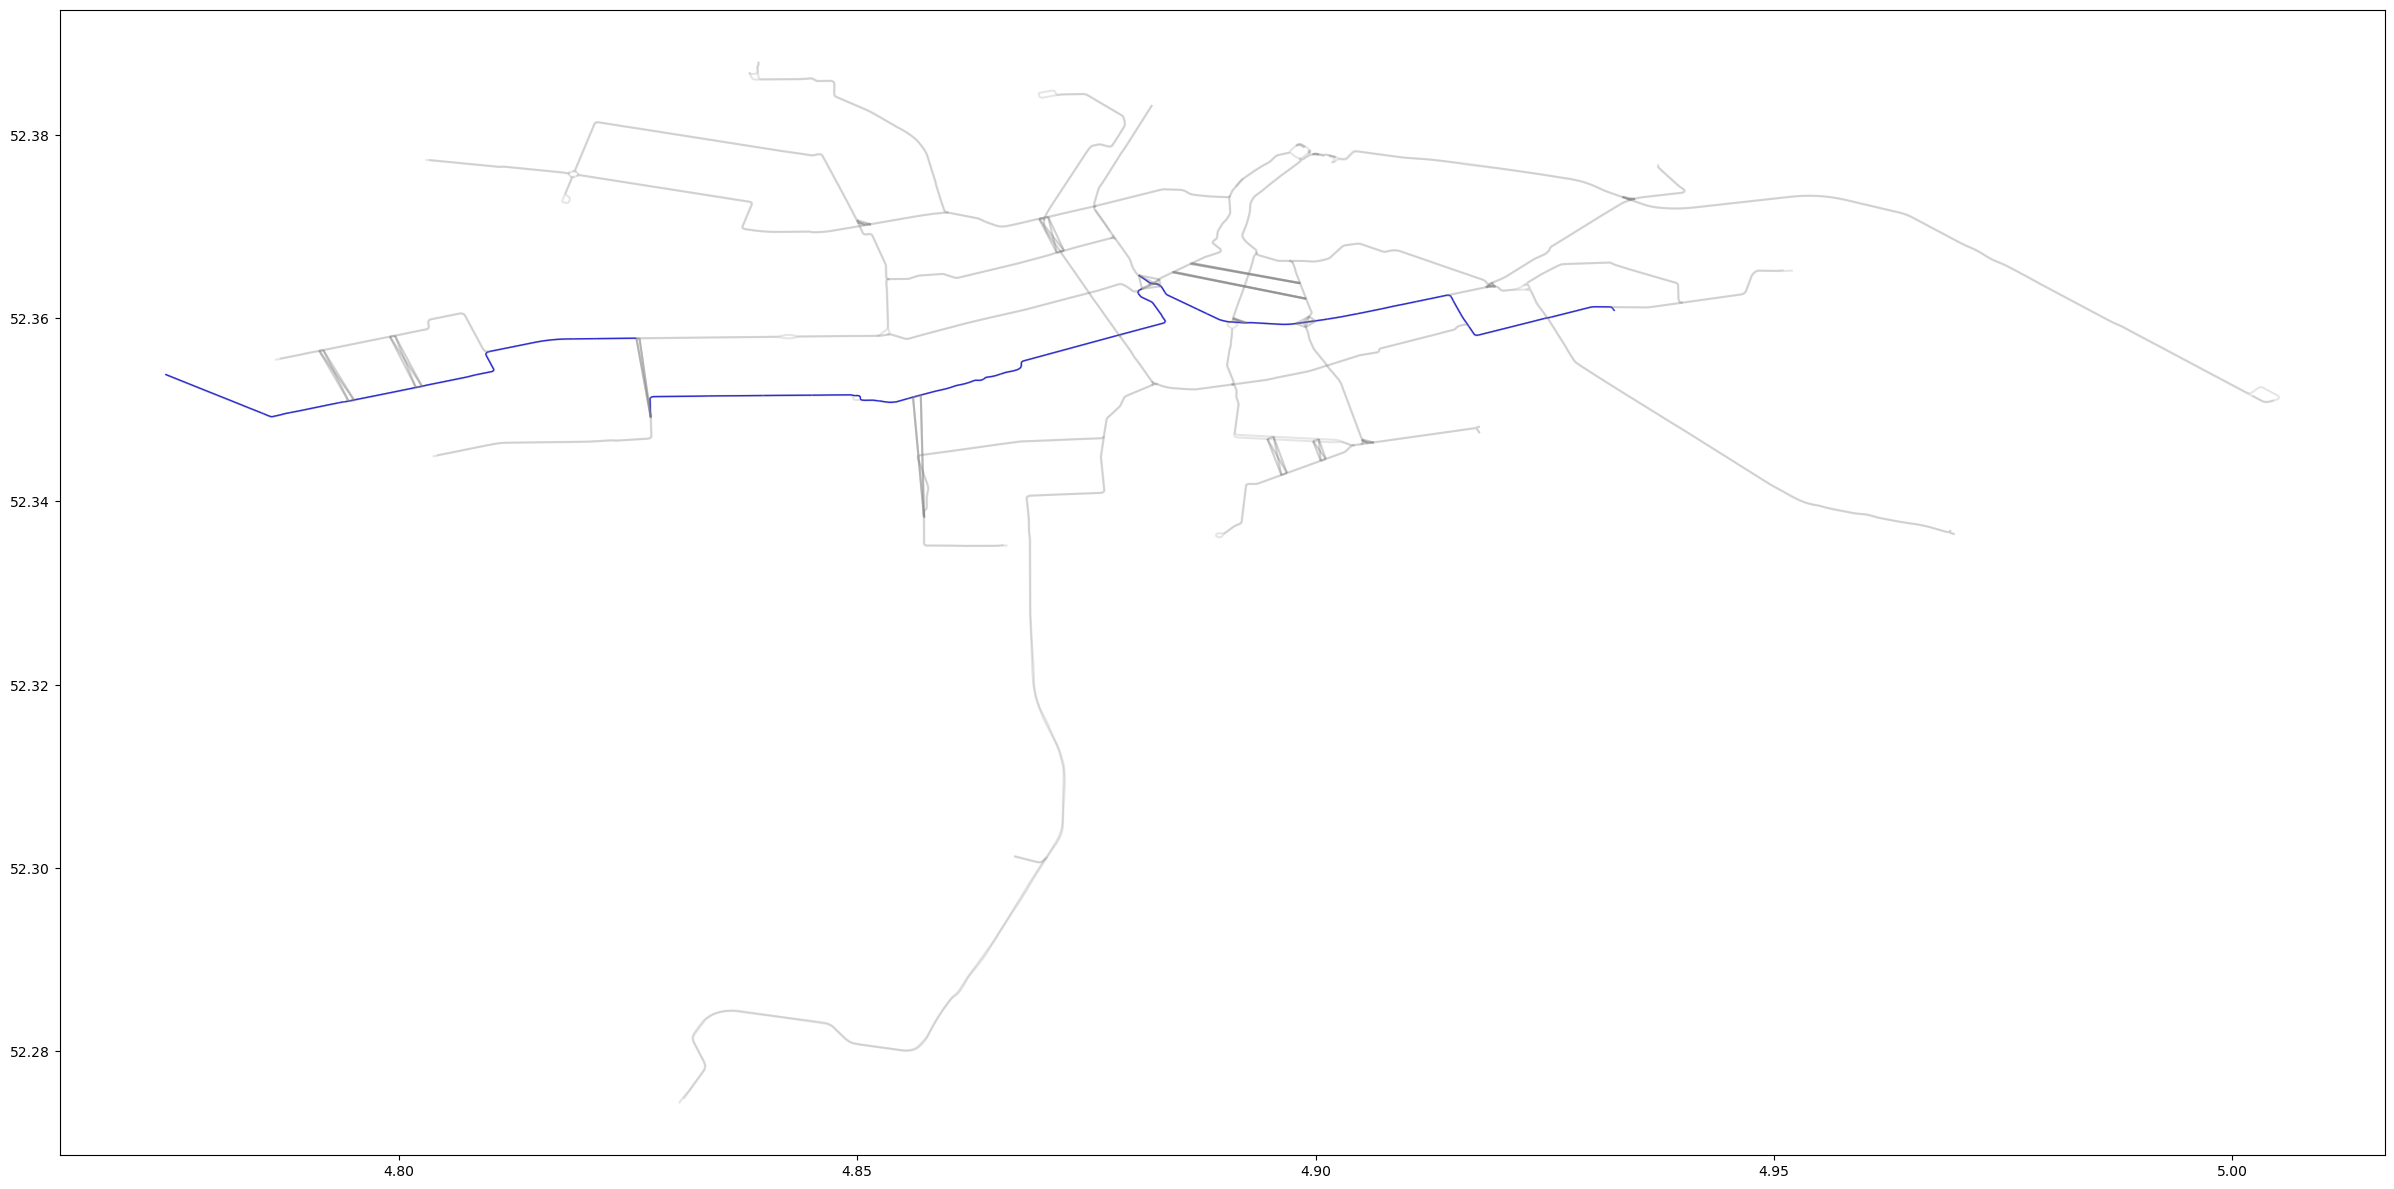

In [58]:
df = OD_shortest_path_edges[0]
plot_chosen_single_transport(city_tram_connected_edges,df)

## Test OD pairs under disruptions

In [59]:
def remove_edges_by_percentage(graph, percentage):
    num_edges_to_remove = int(len(graph.edges) * percentage)
    
    edges_to_remove = random.sample(graph.edges, num_edges_to_remove)
    
    graph.remove_edges_from(edges_to_remove)
    return edges_to_remove

In [60]:
remove_edges_by_percentage(G1, 0.01)

[(1874, 1719.0),
 (479, 1838.0),
 (1785, 1577.0),
 (1339, 155.0),
 (1889, 1820.0),
 (251, 252.0),
 (197, 1841.0),
 (894, 895.0),
 (1277, 1275.0),
 (1688, 1774.0),
 (294, 185.0),
 (1795, 1452.0),
 (1000, 1893.0),
 (1564, 1723.0),
 (1559, 531.0),
 (334, 437.0)]

In [61]:
OD_dis_shortest_path_nodes_id = {}
OD_dis_shortest_path_edges = {}
OD_dis_length_s_e = {}
for index, row in OD_id_pairs_df.iterrows():
    try:
        path_s_e, length_s_e, short_path_edges = shortest_path(G1, row.s_id, row.e_id, city_tram_connected_edges, weight = "weights")
        OD_dis_shortest_path_nodes_id[index] = path_s_e
        OD_dis_shortest_path_edges[index] = short_path_edges
        OD_dis_length_s_e[index] = length_s_e
    except nx.NetworkXNoPath:
        print(f"No path between {row.s_id} and {row.e_id}. Skipping...")
        continue

No path between 1341 and 1432. Skipping...
No path between 1341 and 546. Skipping...
No path between 1341 and 790. Skipping...
No path between 1341 and 1166. Skipping...
No path between 1341 and 1128. Skipping...
No path between 1341 and 414. Skipping...
No path between 271 and 1432. Skipping...
No path between 271 and 546. Skipping...
No path between 271 and 790. Skipping...
No path between 271 and 1166. Skipping...
No path between 271 and 1128. Skipping...
No path between 271 and 414. Skipping...
No path between 1309 and 1432. Skipping...
No path between 1309 and 546. Skipping...
No path between 1309 and 1166. Skipping...
No path between 1309 and 1128. Skipping...
No path between 1309 and 414. Skipping...
No path between 1233 and 1432. Skipping...
No path between 1233 and 546. Skipping...
No path between 1233 and 790. Skipping...
No path between 1233 and 1166. Skipping...
No path between 1233 and 1128. Skipping...
No path between 1233 and 414. Skipping...
No path between 1305 and 143

In [62]:
len(OD_dis_shortest_path_edges)

420

In [63]:
OD_dis_shortest_path_edges

{0:           osm_id                                           geometry railway  \
 0        7045610  LINESTRING (4.9324018 52.3610615, 4.932387 52....    tram   
 6        7046455  LINESTRING (4.9249426 52.3599582, 4.9242892 52...    tram   
 80      10529538  LINESTRING (4.9164141 52.3595469, 4.9163718 52...    tram   
 121     26594761  LINESTRING (4.785218 52.3495798, 4.7849725 52....    tram   
 134     27028860  LINESTRING (4.8547631 52.3579067, 4.8543098 52...    tram   
 ...          ...                                                ...     ...   
 1481  1108405768  LINESTRING (4.9166572 52.359197, 4.9165754 52....    tram   
 1561         NaN  LINESTRING (4.8018381 52.3524376, 4.7990044 52...     NaN   
 1566         NaN  LINESTRING (4.7990044 52.3579858, 4.8018381 52...     NaN   
 1598         NaN  LINESTRING (4.8810698 52.3632085, 4.8806933 52...     NaN   
 1605         NaN  LINESTRING (4.8806933 52.3646825, 4.8810698 52...     NaN   
 
      service    id  from_id  to_id

In [64]:
# plot_OD_routes(OD_dis_shortest_path_edges,city_tram_connected_edges)

In [65]:
# gpd.GeoDataFrame(city_tram_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_tram_edges_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_tram_stations[['osm_id', 'geometry','name']]).to_file('city_tram_stations_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_tram_nodes[['geometry','degree','id']]).to_file('city_tram_nodes_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_tram_routes[['osm_id', 'route', 'name', 'geometry']]).to_file('city_tram_routes_0417.GPKG',driver='GPKG')

In [66]:
# gpd.GeoDataFrame(city_tram_new_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_tram_new_edges_0418.GPKG',driver='GPKG')

In [67]:
# gpd.GeoDataFrame(city_tram_new_nodes[['geometry','degree','id']]).to_file('city_tram_new_nodes_0419.GPKG',driver='GPKG')

In [69]:
gpd.GeoDataFrame(city_tram_connected_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_tram_connected_edges_0424.GPKG',driver='GPKG')

In [70]:
gpd.GeoDataFrame(df[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('df_tram0424.GPKG',driver='GPKG')

## Create more OD pair in another way

In [57]:
origin_df = pd.DataFrame()
each_o_point = pd.DataFrame()

for route_name, station_df in city_tram_order_route_dict.items():
    each_o_point = station_df.loc[[0]]
    origin_df = pd.concat([origin_df,each_o_point])

origin_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','name']
origin_df = origin_df[selected_columns].reset_index(drop=True)
origin_id_df = pd.merge(origin_df,city_tram_new_nodes,on='geometry',how='left')

In [58]:
origin_df

geometry                      name
0   POINT (4.9326128 52.3607965)        Muiderpoortstation
1   POINT (4.7747567 52.3537327)                Matterhorn
2   POINT (4.8992878 52.3783193)          Centraal Station
3    POINT (4.9178945 52.347445)             Amstelstation
4    POINT (4.8992178 52.378303)          Centraal Station
5   POINT (4.8029118 52.3772607)       Lambertus Zijlplein
6   POINT (4.9003629 52.3778505)          Centraal Station
7   POINT (4.9510568 52.3652467)                 Flevopark
8   POINT (4.8991546 52.3782813)          Centraal Station
9   POINT (4.7864929 52.3554481)            Dijkgraafplein
10  POINT (4.8392172 52.3879696)        Station Sloterdijk
11  POINT (4.9697229 52.3364299)                     Sniep
12  POINT (4.8993575 52.3783416)          Centraal Station
13  POINT (4.8036706 52.3449284)       Oudenaardeplantsoen
14  POINT (4.9003819 52.3778942)          Centraal Station
15  POINT (4.8659833 52.3352308)           De Boelelaan/VU
16  POINT (4.8310348 52.2748113)                  Westwijk
17  POINT (4.8731849 52.3408165)              Station Zuid
18  POINT (5.0049024 52.3511345)                    IJburg
19  POINT (4.9009769 52.3778507)          Centraal Station
20  POINT (4.8698541 52.3842644)            Van Hallstraat
21   POINT (4.889801 52.3362207)                Drentepark
22  POINT (4.9003434 52.3778058)          Centraal Station
23  POINT (4.8670933 52.3012694)      Amstelveen Stadshart
24   POINT (4.8821775 52.383238)  Eerste Marnixdwarsstraat
25  POINT (4.9373223 52.3766133)                Azartplein
26  POINT (4.8186019 52.3728449)                Sloterpark

In [59]:
origin_id_df

geometry                      name    id  degree
0   POINT (4.9326128 52.3607965)        Muiderpoortstation  1341       2
1   POINT (4.7747567 52.3537327)                Matterhorn   271       2
2   POINT (4.8992878 52.3783193)          Centraal Station  1309       2
3    POINT (4.9178945 52.347445)             Amstelstation  1233       2
4    POINT (4.8992178 52.378303)          Centraal Station  1305       2
5   POINT (4.8029118 52.3772607)       Lambertus Zijlplein   237       2
6   POINT (4.9003629 52.3778505)          Centraal Station   676       2
7   POINT (4.9510568 52.3652467)                 Flevopark  1170       2
8   POINT (4.8991546 52.3782813)          Centraal Station  1312       2
9   POINT (4.7864929 52.3554481)            Dijkgraafplein   268       2
10  POINT (4.8392172 52.3879696)        Station Sloterdijk   634       2
11  POINT (4.9697229 52.3364299)                     Sniep  1344       2
12  POINT (4.8993575 52.3783416)          Centraal Station  1310       2
13  POINT (4.8036706 52.3449284)       Oudenaardeplantsoen   161       2
14  POINT (4.9003819 52.3778942)          Centraal Station   491       2
15  POINT (4.8659833 52.3352308)           De Boelelaan/VU   360       2
16  POINT (4.8310348 52.2748113)                  Westwijk  1114       2
17  POINT (4.8731849 52.3408165)              Station Zuid   200       2
18  POINT (5.0049024 52.3511345)                    IJburg  1166       2
19  POINT (4.9009769 52.3778507)          Centraal Station   790       2
20  POINT (4.8698541 52.3842644)            Van Hallstraat  1169       2
21   POINT (4.889801 52.3362207)                Drentepark   795       2
22  POINT (4.9003434 52.3778058)          Centraal Station   791       2
23  POINT (4.8670933 52.3012694)      Amstelveen Stadshart   191       2
24   POINT (4.8821775 52.383238)  Eerste Marnixdwarsstraat  1899       2
25  POINT (4.9373223 52.3766133)                Azartplein  1168       2
26  POINT (4.8186019 52.3728449)                Sloterpark   222       2

In [60]:
merge_df = pd.DataFrame(origin_df['name'])
end_stations_df = pd.merge(merge_df, city_tram_stations, on = 'name', how = 'left')
selected_columns = ['geometry','name']
end_stations_df = end_stations_df[selected_columns].reset_index(drop=True)
# end_stations_df = end_stations_df.rename(columns={'geometry_x':'geometry'})
end_stations_df

geometry                      name
0    POINT (4.93285 52.36121)        Muiderpoortstation
1    POINT (4.93363 52.36117)        Muiderpoortstation
2    POINT (4.93261 52.36080)        Muiderpoortstation
3    POINT (4.77476 52.35373)                Matterhorn
4    POINT (4.77450 52.35387)                Matterhorn
..                        ...                       ...
188  POINT (4.86715 52.30135)      Amstelveen Stadshart
189  POINT (4.88218 52.38324)  Eerste Marnixdwarsstraat
190  POINT (4.93735 52.37682)                Azartplein
191  POINT (4.93732 52.37661)                Azartplein
192  POINT (4.81860 52.37284)                Sloterpark

[193 rows x 2 columns]

In [65]:
destination_rows = []

for index2, row2 in origin_df.iterrows():
    
    for index1, row1 in end_stations_df.iterrows():
        if row2['name']== row1['name']:
        
            if not row2['geometry'].equals(row1['geometry']):

                destination_rows.append(row1)


destination_df = pd.DataFrame(destination_rows)
destination_df.drop_duplicates(subset = 'geometry', inplace = True)

destination_df.reset_index(drop=True, inplace=True)
destination_id_df = pd.merge(destination_df,city_tram_nodes,on='geometry',how='left')

In [62]:
destination_id_df

geometry                  name      id  degree
0   POINT (4.9328494 52.3612127)    Muiderpoortstation  1583.0     2.0
1   POINT (4.9336328 52.3611749)    Muiderpoortstation   972.0     2.0
2   POINT (4.7745043 52.3538687)            Matterhorn   847.0     2.0
3   POINT (4.9003819 52.3778942)      Centraal Station   491.0     2.0
4   POINT (4.9009769 52.3778507)      Centraal Station   790.0     2.0
5   POINT (4.9003434 52.3778058)      Centraal Station   791.0     2.0
6   POINT (4.9003629 52.3778505)      Centraal Station   676.0     2.0
7    POINT (4.902591 52.3790626)      Centraal Station     NaN     NaN
8   POINT (4.8991546 52.3782813)      Centraal Station  1312.0     2.0
9    POINT (4.8992178 52.378303)      Centraal Station  1305.0     2.0
10  POINT (4.8988712 52.3786582)      Centraal Station  1886.0     2.0
11   POINT (4.8989173 52.378697)      Centraal Station  1887.0     2.0
12  POINT (4.8993575 52.3783416)      Centraal Station  1310.0     2.0
13  POINT (4.9004043 52.3779466)      Centraal Station     NaN     NaN
14  POINT (4.9009807 52.3777002)      Centraal Station  1908.0     2.0
15  POINT (4.9009806 52.3777485)      Centraal Station  1909.0     2.0
16  POINT (4.9009723 52.3777976)      Centraal Station  1910.0     2.0
17  POINT (4.8987647 52.3785952)      Centraal Station  1911.0     2.0
18  POINT (4.8988204 52.3786244)      Centraal Station  1912.0     2.0
19  POINT (4.9009743 52.3778019)      Centraal Station     NaN     NaN
20  POINT (4.9009825 52.3777528)      Centraal Station     NaN     NaN
21  POINT (4.9009826 52.3777045)      Centraal Station     NaN     NaN
22  POINT (4.9178096 52.3474274)         Amstelstation     NaN     NaN
23  POINT (4.8992878 52.3783193)      Centraal Station  1309.0     2.0
24  POINT (4.8032895 52.3772583)   Lambertus Zijlplein   233.0     2.0
25  POINT (4.9520639 52.3652037)             Flevopark   292.0     2.0
26  POINT (4.7870176 52.3555825)        Dijkgraafplein   269.0     2.0
27  POINT (4.8041222 52.3450454)   Oudenaardeplantsoen   175.0     2.0
28  POINT (4.8663865 52.3351971)       De Boelelaan/VU   363.0     2.0
29  POINT (4.8305377 52.2743532)              Westwijk   546.0     2.0
30  POINT (4.8739688 52.3408227)          Station Zuid  1432.0     2.0
31  POINT (4.8671267 52.3013177)  Amstelveen Stadshart  1128.0     2.0
32   POINT (4.867149 52.3013453)  Amstelveen Stadshart     NaN     NaN
33  POINT (4.9373469 52.3768181)            Azartplein   414.0     2.0

In [63]:
OD_id_list = []

for index_origin, row_origin in origin_id_df.iterrows():

       
    for index_destination, row_destination in destination_id_df.iterrows():


        if row_origin['name'] != row_destination['name']:
            # Append a dictionary to the list
            OD_id_list.append({
                's_id': row_origin['id'],
                'e_id': row_destination['id']
             })

# Create a DataFrame from the list of dictionaries
OD_id_pairs_df = pd.DataFrame(OD_id_list)  
OD_id_pairs_df

s_id    e_id
0    1341   847.0
1    1341   491.0
2    1341   790.0
3    1341   791.0
4    1341   676.0
..    ...     ...
739   222   546.0
740   222  1432.0
741   222  1128.0
742   222     NaN
743   222   414.0

[744 rows x 2 columns]